# 12-lead ECG disease prediction

## 1. Data Preparation Phase

**Aim:** Prepare clean, balanced datasets for training, validation, and testing.

**Steps:**

- Load and preprocess raw ECG data
- Standardize cardiac condition classification
- Split data (development/validation) using stratification
- Calculate HRV and other features consistently

**Key Plots:**

- Class distribution histograms
- Feature distributions and bosplots
- Missing value analysis

### Loading data

In [21]:
# !python -V > full_requirements.txt && pip list --format=freeze >> full_requirements.txt

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import joblib
from pathlib import Path
%matplotlib inline

from src.data_processing import load_processed_data
from src.auxiliary import map_cardiac_condition, pathology_severity_groups, histogram_labels, analyze_feature_distributions, assess_missing_values, add_hr_metrics, plot_grouped_boxplots
from ecg_data_pipeline import ECGFeatureExtractor, CardiacConditionClassifier, ECGPipeline

# Load development indices
dev_indices = np.load('./Results/dev_indices.npy', allow_pickle=True)

#Load development data
data_path = './Results/processed_data'
try:
   dev_ecg_dict, dev_data = load_processed_data(data_path, indices= dev_indices)
   print(f"Loaded data for {len(dev_data)} patients")
except (FileNotFoundError, StopIteration):
   raise FileNotFoundError("Preprocessed data not found. Please run data_processing.py first")

dev_ecg = {k: v['ecg_signals_filtered'] for k, v in dev_ecg_dict.items()}
del dev_ecg_dict

print("Development set size:", len(dev_indices))

dev_data.head()

Loading patient data: 100%|██████████| 31606/31606 [01:25<00:00, 368.12it/s]


2025-02-27 00:09:11 - load_processed_data took 1.43 minutes
Loaded data for 31606 patients
Development set size: 31606


,age,sex,diagnosis_code,diagnosis_name
JS00067,77.0,Male,"['164889003', '55827005', '428750005']",NaN
JS00066,62.0,Male,['426177001'],['Sinus Bradycardia']
JS00099,49.0,Female,"['426177001', '164934002']","['Sinus Bradycardia', 'T wave Change']"
JS00070,58.0,Male,['426783006'],['Sinus Rhythm']
JS00064,71.0,Female,"['164889003', '55827005', '164934002']",NaN


### Cadiopathology grouping



This classification organizes heart rhythm and conduction patterns in a way that mirrors how cardiologists think about ECG interpretation:

- Ischemic Disorders: Signs of heart muscle damage or oxygen starvation, including heart attacks and warning signs like ST segment changes
- Primary Electrical Disorders: Abnormal heart rhythms originating from problems with the heart's electrical system itself, rather than from structural damage
- Conduction System Disease: Problems with how electrical signals travel through the heart, causing delays or blocks in normal conduction
- Chamber Abnormalities: Enlarged or thickened heart chambers that change how electrical signals appear on ECG (extra snomed codes not related to ecg diagnosis like left ventricular hypertrophy from other diagnostic sources have been skipped.)
- Atrial Abnormalities: Specific issues affecting the upper chambers of the heart
- Benign Variants: Normal variations that don't require treatment but should be distinguished from disease
- Normal: Completely normal heart rhythm and conduction

This approach follows the American College of Cardiology's guidelines for ECG interpretation and helps clinicians prioritize findings based on their clinical significance.


The code below selects only one condition per patient, priorizing the condition of highest severity. 

Conditions outside those listed in the snomed condition csv are excluded (classified as other) because those might be not ecg related, but previously diagnosed, therefore not interesting for this classsifier.

In [23]:
# Initialize condition classifier
condition_classifier = CardiacConditionClassifier(pathology_hierarchy=pathology_severity_groups)

# Transform diagnosis codes into cardiac condition categories
dev_data = condition_classifier.transform(dev_data)
dev_labels = dev_data['diagnosis_label']



dev_data.head(10)

,age,sex,diagnosis_code,diagnosis_name,diagnosis_label
JS00067,77.0,Male,"['164889003', '55827005', '428750005']",NaN,Ischemic Disorders
JS00066,62.0,Male,['426177001'],['Sinus Bradycardia'],Benign Variants
JS00099,49.0,Female,"['426177001', '164934002']","['Sinus Bradycardia', 'T wave Change']",Ischemic Disorders
JS00070,58.0,Male,['426783006'],['Sinus Rhythm'],Normal
JS00064,71.0,Female,"['164889003', '55827005', '164934002']",NaN,Ischemic Disorders
JS00058,63.0,Female,['426783006'],['Sinus Rhythm'],Normal
JS00071,76.0,Female,"['164889003', '698252002', '55827005', '428750...",NaN,Ischemic Disorders
JS00049,85.0,Male,"['426177001', '39732003']","['Sinus Bradycardia', 'Axis left shift']",Chamber Abnormalities
JS00075,49.0,Male,['426177001'],['Sinus Bradycardia'],Benign Variants
JS00060,80.0,Male,['164889003'],['Atrial Fibrillation'],Primary Electrical Disorders


### Sample histogram

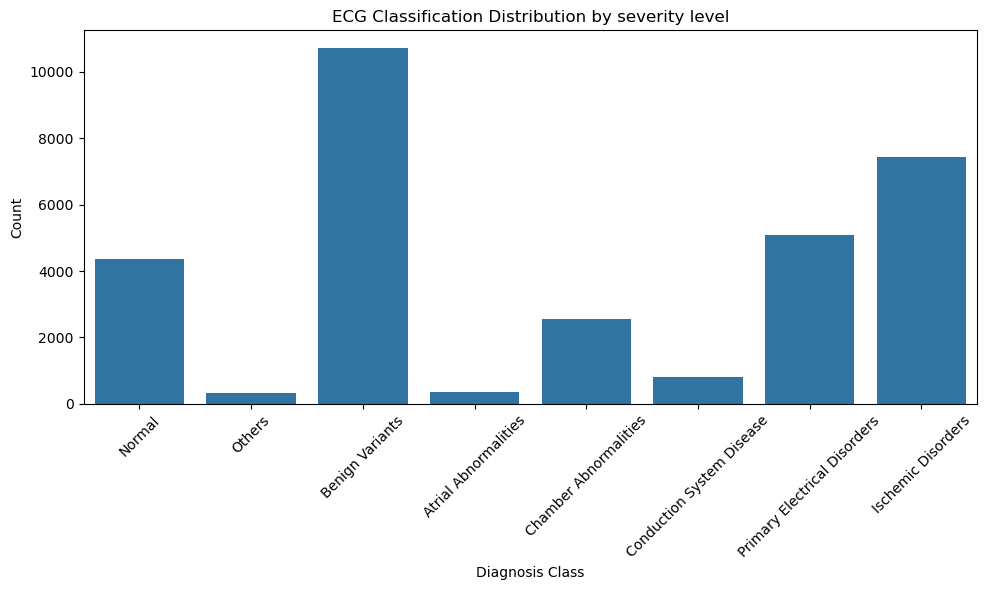

In [24]:
pathology_order = sorted(
    pathology_severity_groups.keys(),
    key=lambda cat: pathology_severity_groups[cat]['severity'],
    reverse=False
)
histogram_labels(dev_labels, pathology_order=pathology_order)

We have a clear unbalance of the dataset:

- Some balancing techniques (downsampling, upsampling etc)
- Using real world prevalences...

In [25]:
diagnosis_counts = dev_data[dev_labels=='Others']['diagnosis_code'].value_counts()
diagnosis_counts[diagnosis_counts > 4]


diagnosis_code
['10370003']                 193
['106068003']                 79
['427172004', '10370003']     11
['251166008']                  5
['111288001']                  5
Name: count, dtype: int64

What is the composition of the codes inside others? Should they be inside any of the actual classes rather than inside others?

From the codes initially found inside others, that were not classified we can find:

- '10370003' -> Artificial pacing
- '106068003' -> Atrial rhythm
- '164896001' -> Ventricular fibrilation
- '81898007' -> Ventricular scape rhythm
- '425856008' -> Paroxismal ventricular tachycardia
- '29320008' -> Ectopic rhythm
- '55827005' -> Left ventricular hypertrophy '106068003' -> Atrial rhythm



These codes were distributes across the grous after some research as follows:

- Primary Electrical Disorders (severity 6):

    - '164896001' (Ventricular fibrillation)
    - '425856008' (Paroxysmal ventricular tachycardia)
    - '81898007' (Ventricular escape rhythm)
    - '29320008' (Ectopic rhythm)


- Chamber Abnormalities (severity 4):

    - '55827005' (Left ventricular hypertrophy)


- Others (severity 1):

    - '10370003' (Artificial pacing) - intervention, not natural condition
    - '106068003' (Atrial rhythm) - too general to classify specifically


### Calculate HRV

In [26]:
# Initialize feature extractor
feature_extractor = ECGFeatureExtractor(fs=500, features_to_extract=['hr_metrics', 'age'])

# Extract features directly from ECG data
extracted_features = feature_extractor.transform(dev_ecg, dev_data)

# Combine with diagnosis label for analysis
dev_hrv = dev_data[['diagnosis_label']].join(extracted_features)
analyse_features = ['median_hr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'age']

### Feature distribution and missing values

Analyzing feature distributions...
Features skewness:
  - median_hr: 1.11
  - mean_hr: 1.05
  - std_hr: 1.81
  - min_hr: 1.42
  - max_hr: 0.90
  - age: -0.80


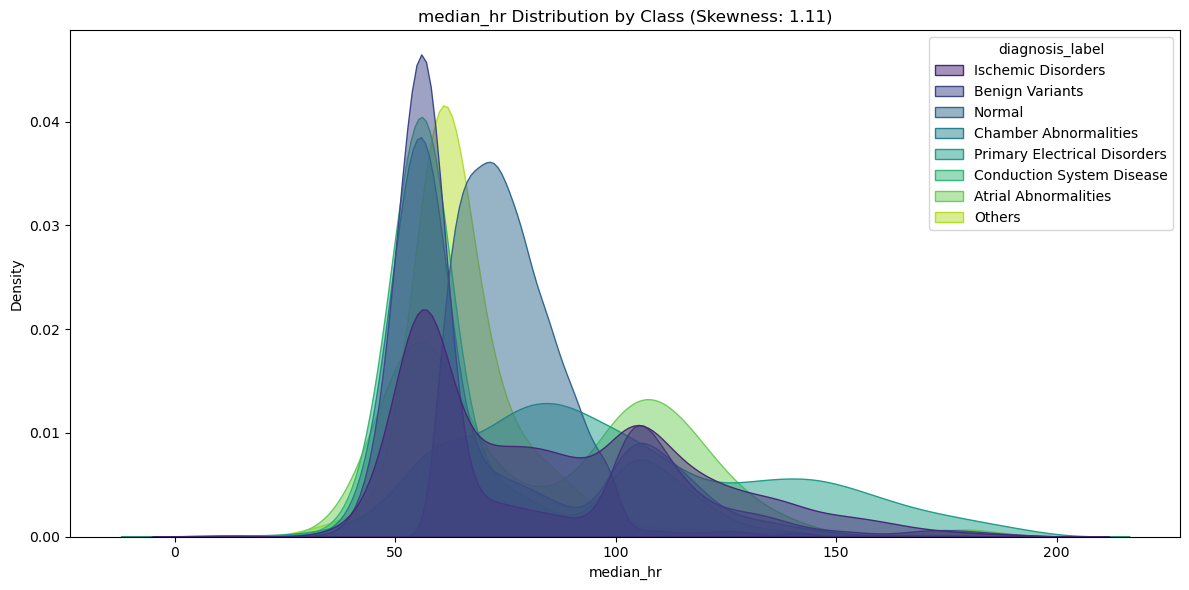

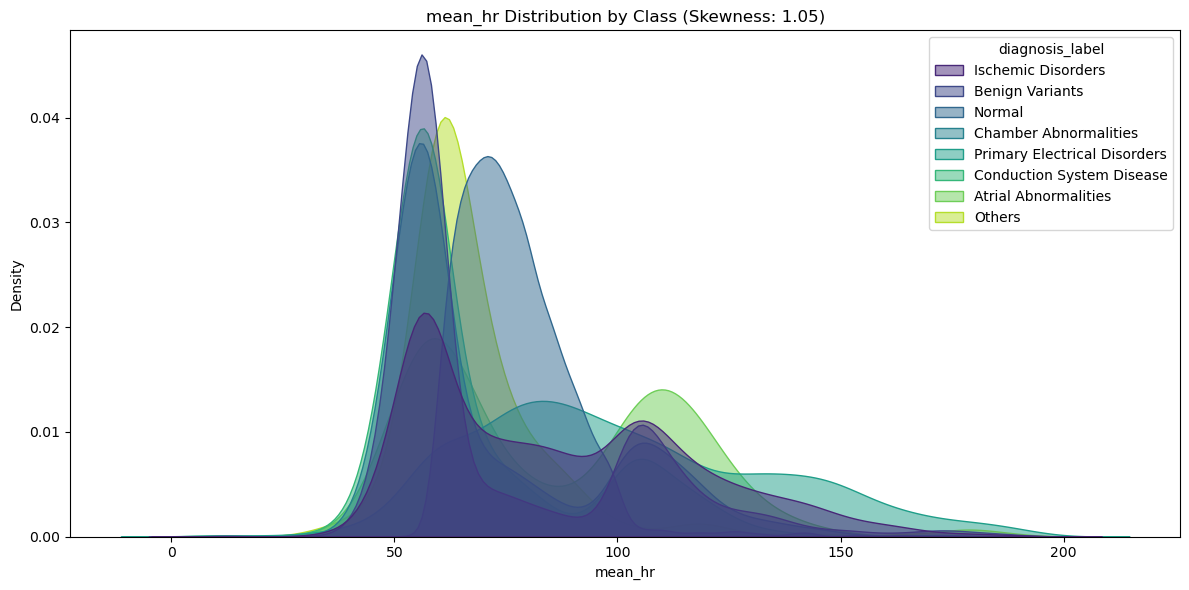

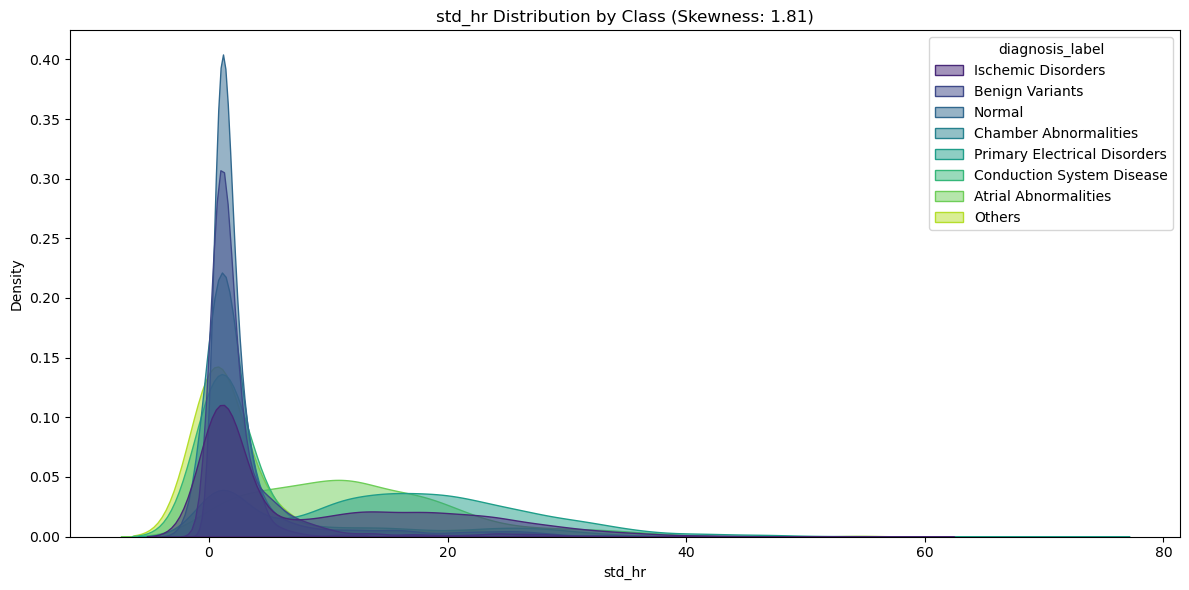

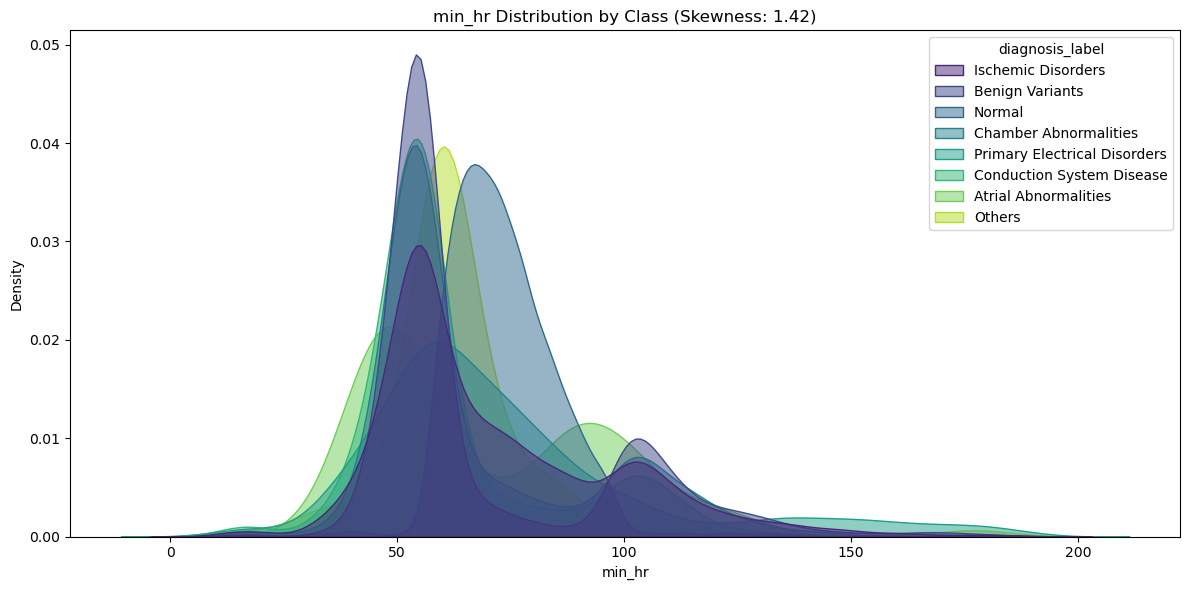

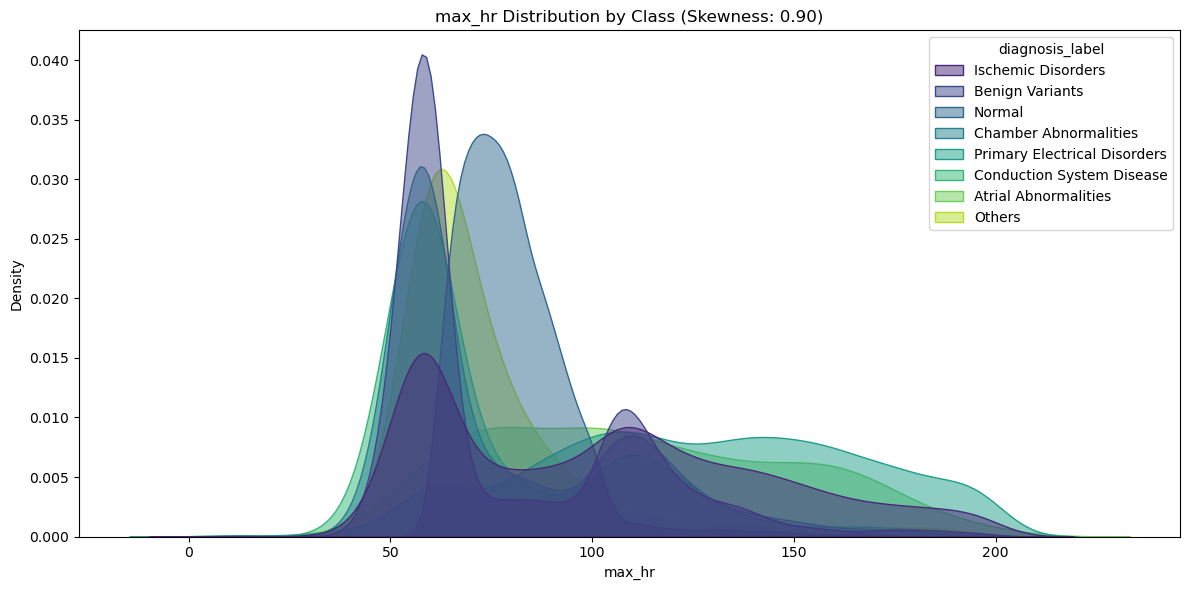

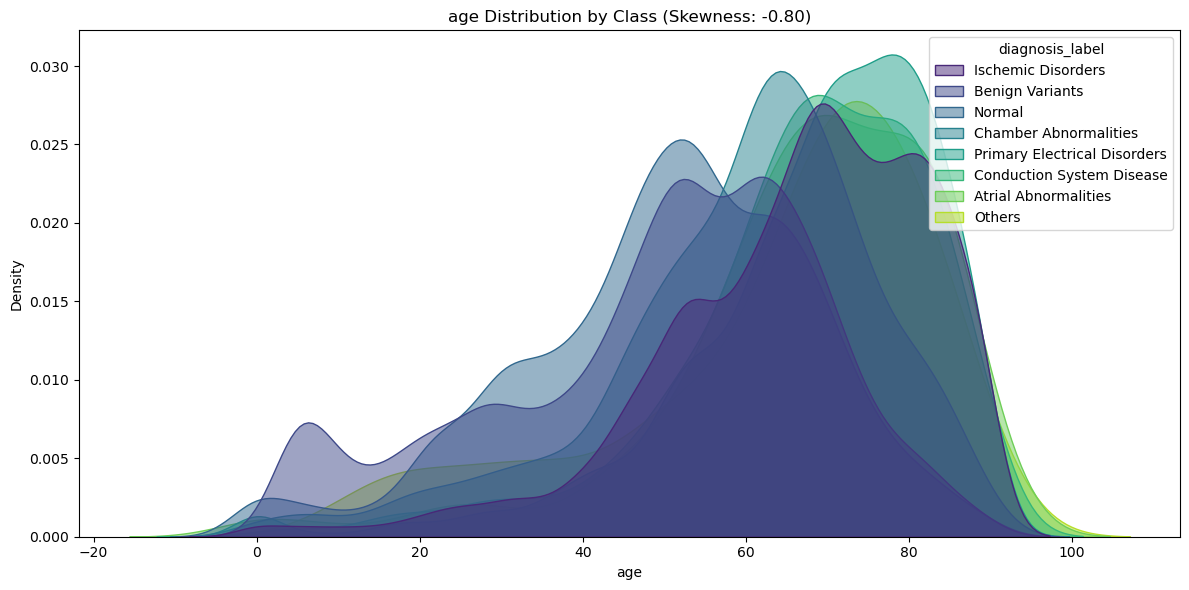


Assessing missing values...
Missing Values Summary:
           Missing Values  Percentage
median_hr             178    0.563184
mean_hr               178    0.563184
std_hr                178    0.563184
min_hr                178    0.563184
max_hr                178    0.563184
age                    38    0.120230


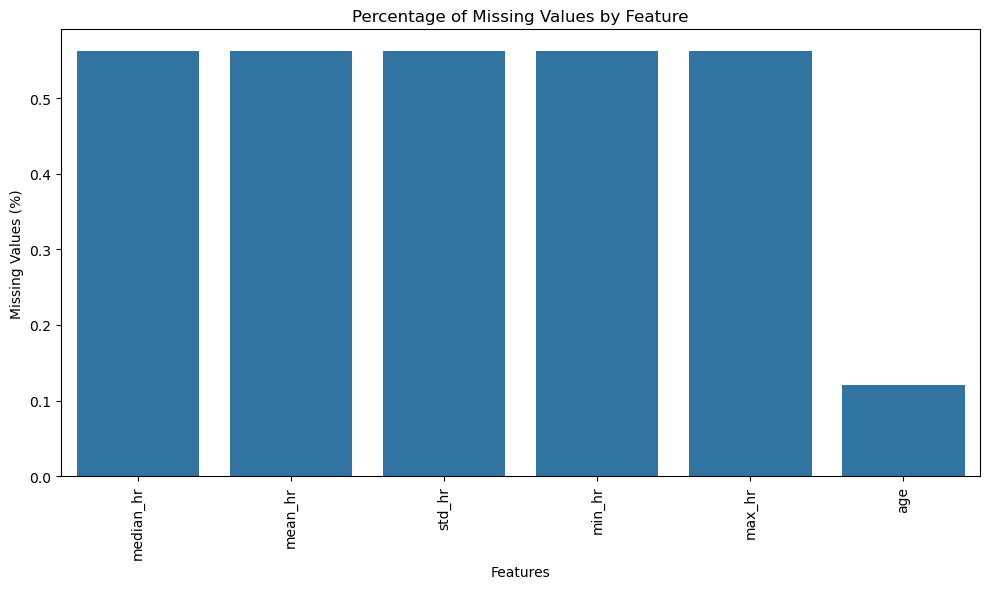

Imputing missing values with median...


In [27]:
print("Analyzing feature distributions...")
analyze_feature_distributions(dev_hrv, analyse_features)

print("\nAssessing missing values...")
missing_summary = assess_missing_values(dev_hrv, analyse_features, 'diagnosis_label')

if missing_summary['Missing Values'].sum() > 0:
    print("Imputing missing values with median...")
    for feature in analyse_features:
        if missing_summary.loc[feature, 'Missing Values'] > 0:
            dev_hrv[feature].fillna(dev_hrv[feature].median(), inplace=True)

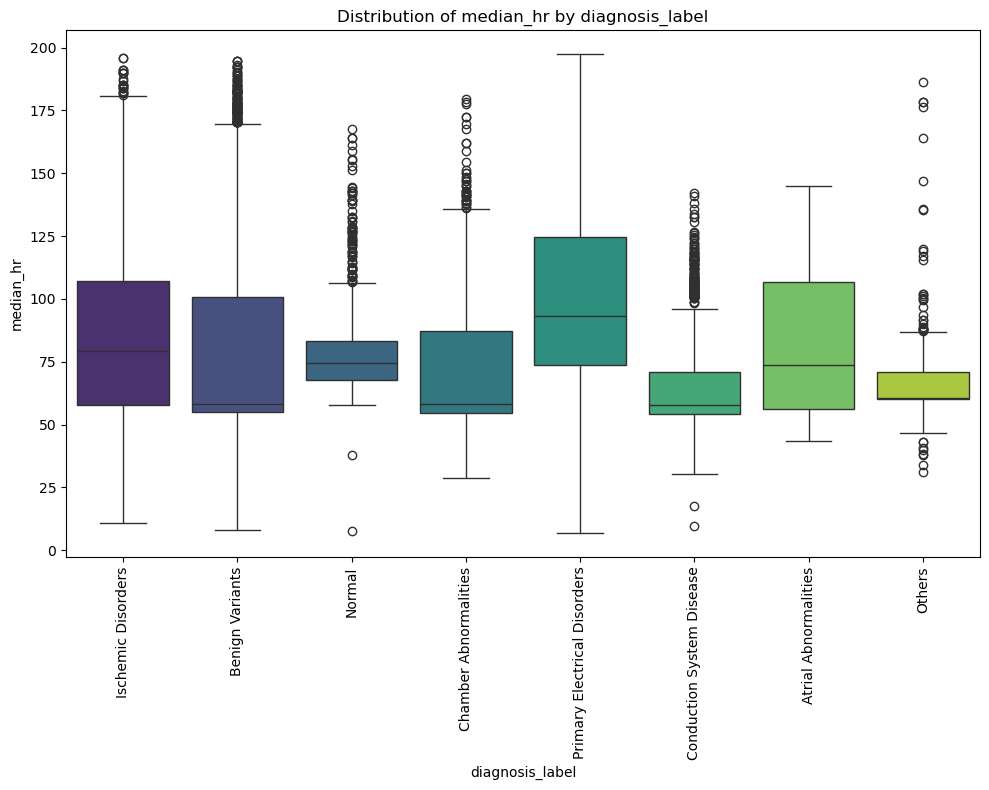

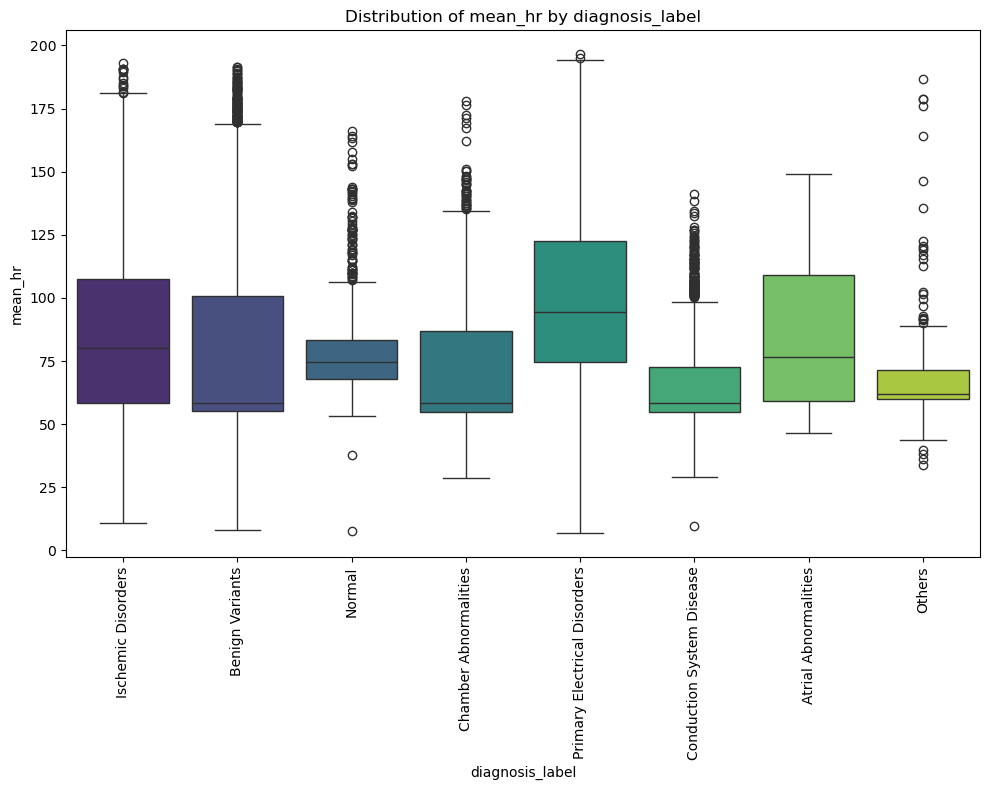

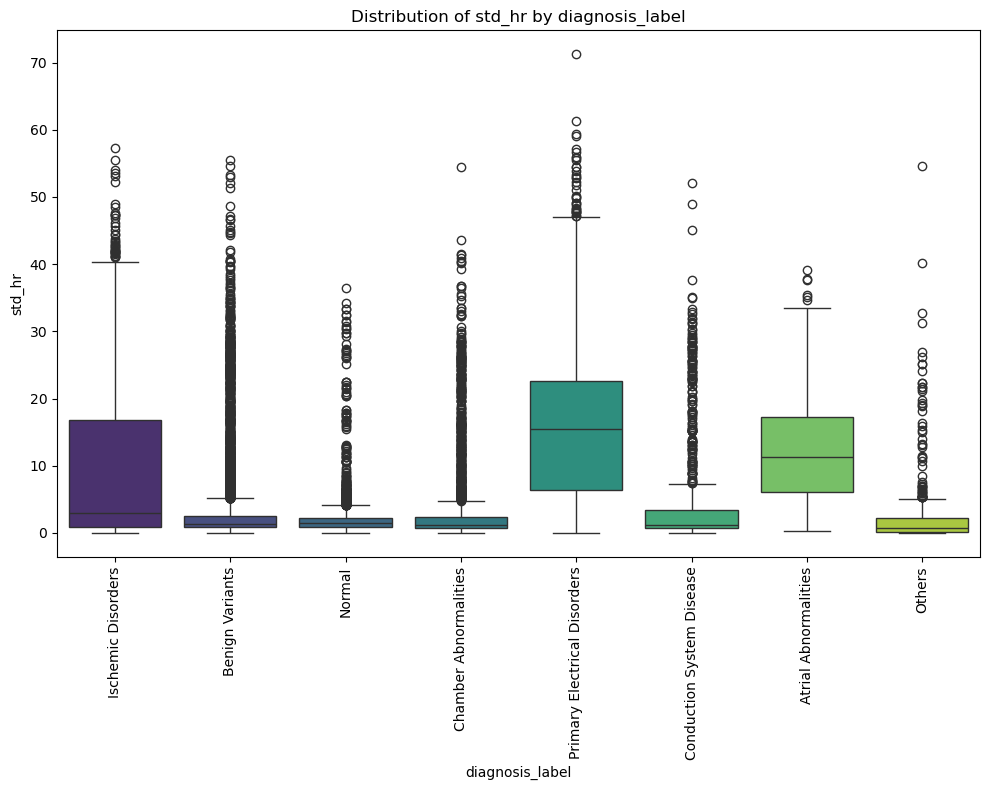

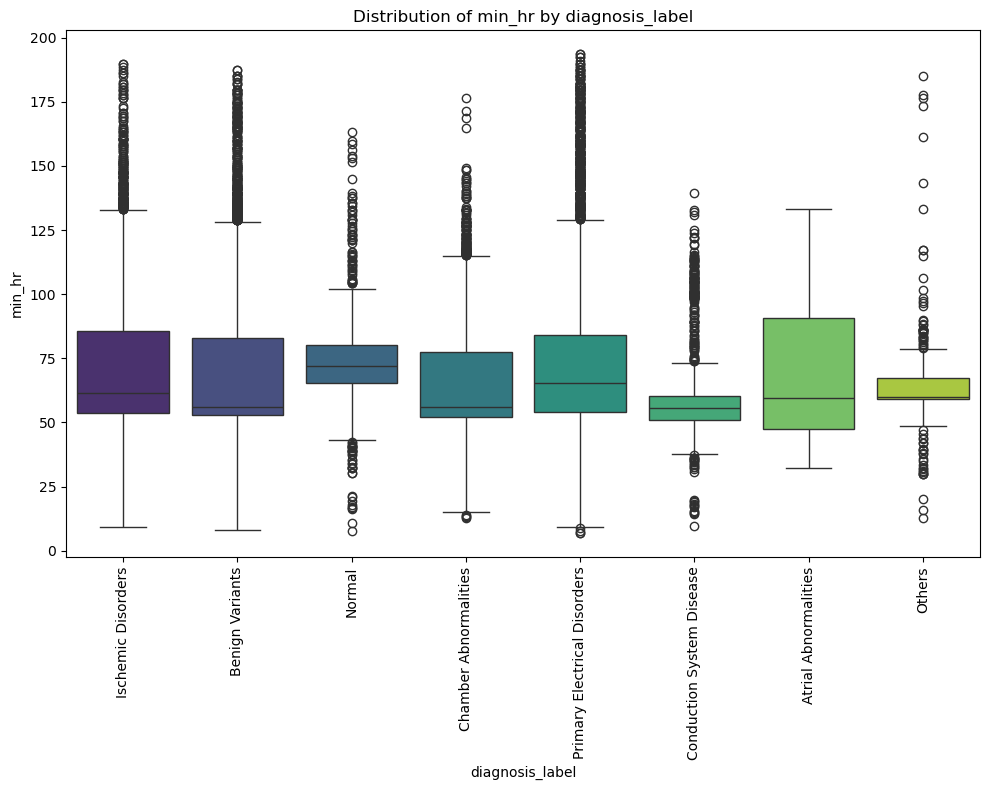

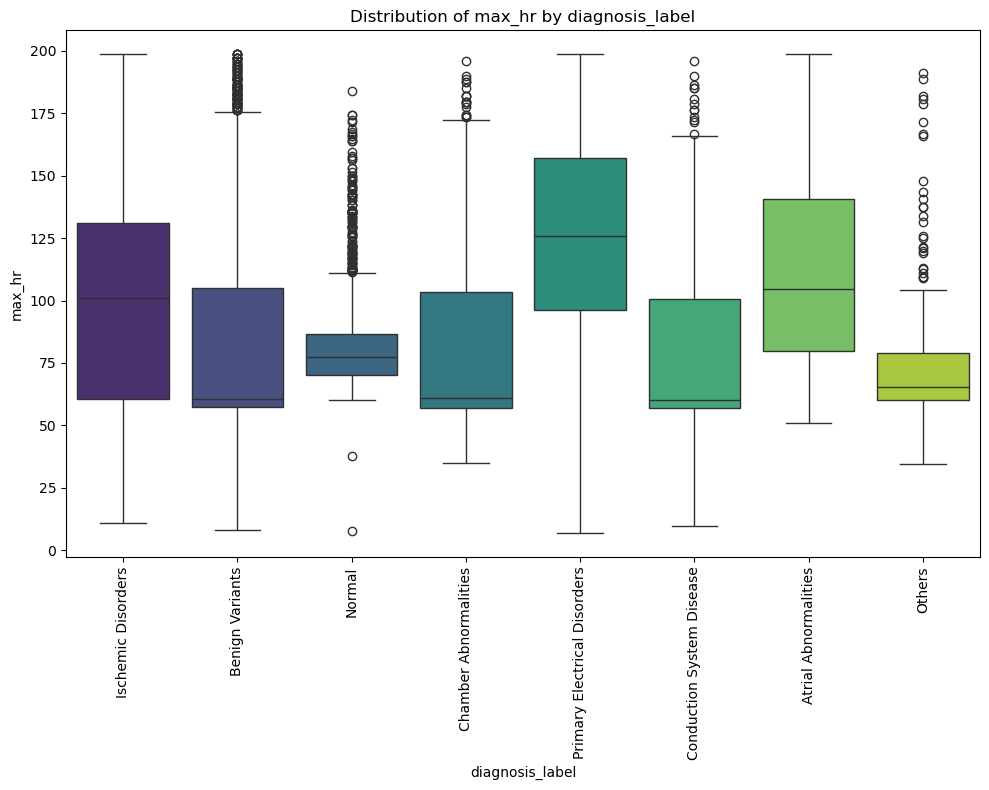

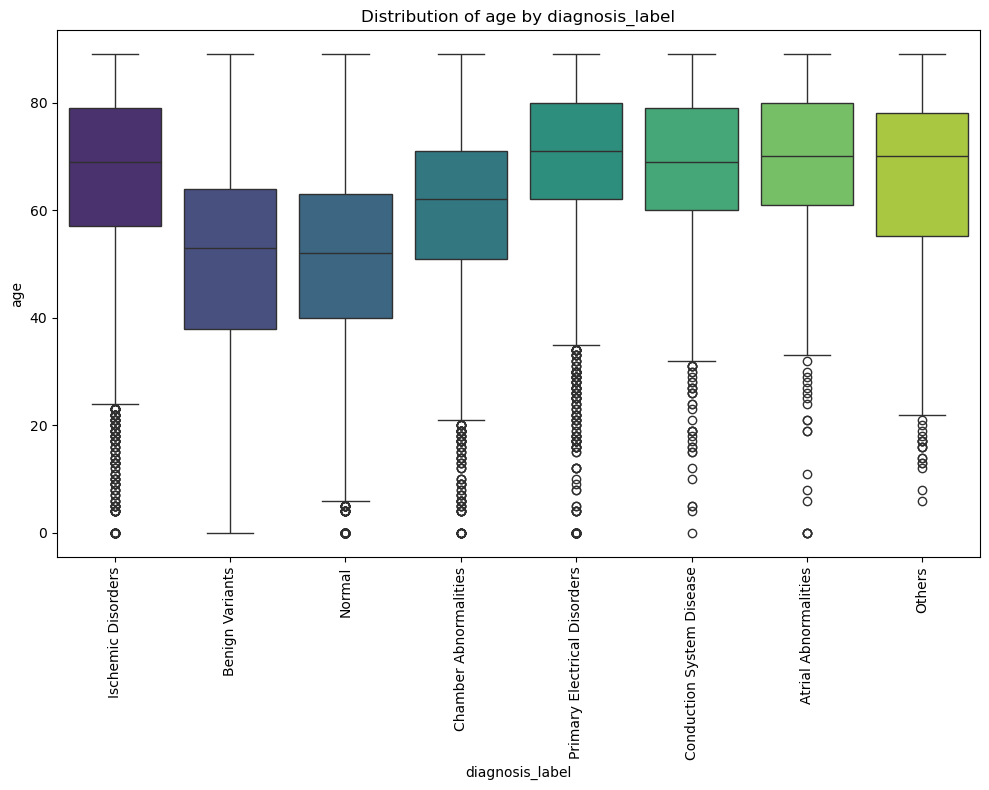

In [28]:
box_data = dev_hrv.copy()
box_data['age_group'] = np.where(box_data['age'] < 65, 'Age < 65', 'Age ≥ 65')
plot_grouped_boxplots(box_data, features=analyse_features, group_var='diagnosis_label', hue_var=None, figsize=(10, 8))

### Explaination on visualization:

There seems to be a clear relationship between the distribution of the variable and the pathology group of the patients. We can see that more or less each pathology group matches with its clinical expected behaviour. For instance **normal and benin variants correlate negatively with age**. **Atrial abnormalities, electrical disorders and ischemia correlate with increased maximum, mean and median standard deviation of the heart frequency.**

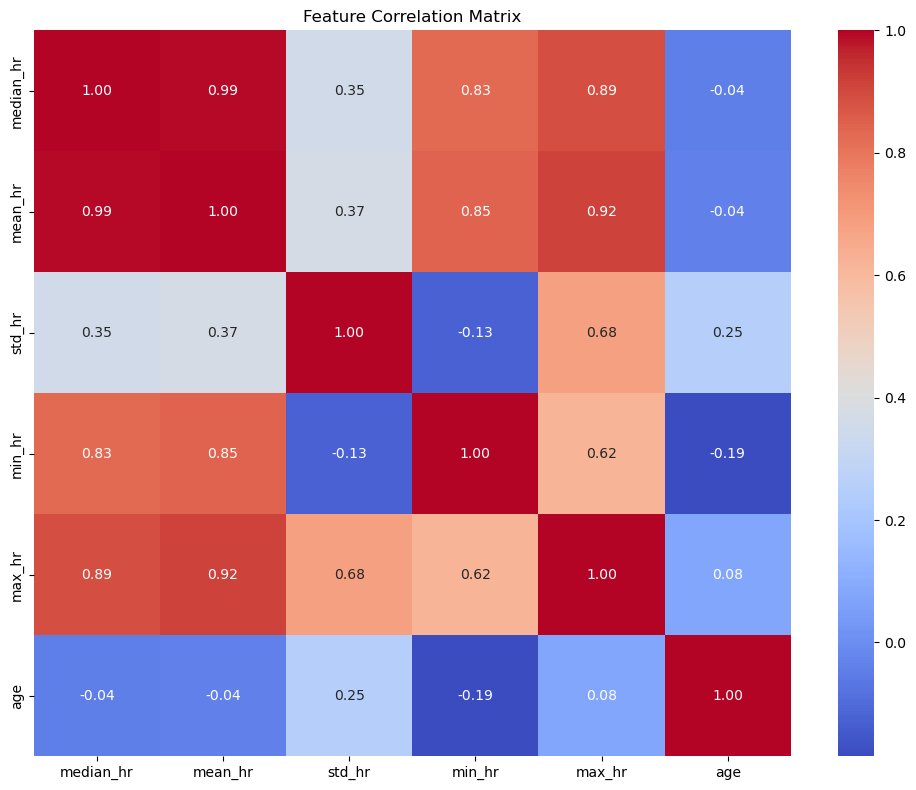

In [29]:
import seaborn as sns

# Correlation matrix of features
plt.figure(figsize=(10, 8))
correlation_matrix = dev_hrv[analyse_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 2. Model Development Phase

**Aim:** Develop and tune your model using cross-validation.

**Steps:**

- Separate development data into trian and test
- Use train data on CV for:
    - performance evaluation (stability of metrics)
    - Perform hyperparameter tuning
    - Analyze feature importance
- Use test data to assess generalization of the tuned model on unseen data
- Train final model on train+test data

**Key Plots:**

- CV performance metrics boxplots
- Feature importance with stability indicators
- ROC curves (one-vs-all) on CV folds
- Decision boundary visualization in PCA space

In [30]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import our restructured pipeline modules
# Assuming they are saved in the src directory
import sys
sys.path.append('./src')
from ecg_data_pipeline import ECGFeatureExtractor, CardiacConditionClassifier, ECGPipeline
from ecg_model_pipeline import ECGModelTrainer, ModelVisualizer, BoundaryVisualizer

### Data split

In [31]:
from src.auxiliary import pathology_severity_groups
# Create the feature matrix and target vector
X = dev_hrv[analyse_features]
y = dev_hrv['diagnosis_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 25284 samples
Testing set: 6322 samples


In [32]:
# Initialize the cardiac condition classifier with the pathology hierarchy
condition_classifier = CardiacConditionClassifier()

# Initialize the feature extractor
feature_extractor = ECGFeatureExtractor(fs=500)

# Initialize the ECG data pipeline
# data_pipeline = ECGPipeline().setup(
#     feature_extractor=feature_extractor,
#     condition_classifier=condition_classifier
# )
# # Initialize the model trainer
model_trainer = ECGModelTrainer(
    n_estimators=100,
    random_state=42,
    feature_scaling=True,
    class_weight='balanced'
)

# Initialize the visualizer
visualizer = ModelVisualizer()

In [33]:
# Preprocess features and encode labels
print("Preprocessing features and encoding labels...")
X_train_processed, y_train_encoded, label_mapping = model_trainer.preprocess(
    X_train, y_train, pathology_severity_groups
)

# Display encoding mapping
print("\nLabel encoding mapping:")
for category, code in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {category} → {code}")

# Encode test labels using the same mapping for evaluation
X_test_processed = model_trainer._preprocess_features(X_test)
y_test_encoded = np.array([label_mapping.get(label, -1) for label in y_test])

# Verify distribution
print(f"\nEncoded label distribution in training set:")
for label in np.unique(y_train_encoded):
    count = np.sum(y_train_encoded == label)
    percent = count / len(y_train_encoded) * 100
    category = [k for k, v in label_mapping.items() if v == label][0]
    print(f"  {category} (code {label}): {count} samples ({percent:.1f}%)")

Preprocessing features and encoding labels...

Label encoding mapping:
  Normal → 0
  Others → 1
  Benign Variants → 2
  Atrial Abnormalities → 3
  Chamber Abnormalities → 4
  Conduction System Disease → 5
  Primary Electrical Disorders → 6
  Ischemic Disorders → 7

Encoded label distribution in training set:
  Normal (code 0): 3490 samples (13.8%)
  Others (code 1): 267 samples (1.1%)
  Benign Variants (code 2): 8571 samples (33.9%)
  Atrial Abnormalities (code 3): 282 samples (1.1%)
  Chamber Abnormalities (code 4): 2035 samples (8.0%)
  Conduction System Disease (code 5): 646 samples (2.6%)
  Primary Electrical Disorders (code 6): 4056 samples (16.0%)
  Ischemic Disorders (code 7): 5937 samples (23.5%)


In [34]:
# Train the model
print("\nTraining Random Forest model...")
model = model_trainer.create_pipeline()
model.fit(X_train_processed, y_train_encoded)
model_trainer.model = model  # Store the model in the trainer

print("Model training complete!")


Training Random Forest model...
Model training complete!



Evaluating model on test set...

Confusion Matrix:


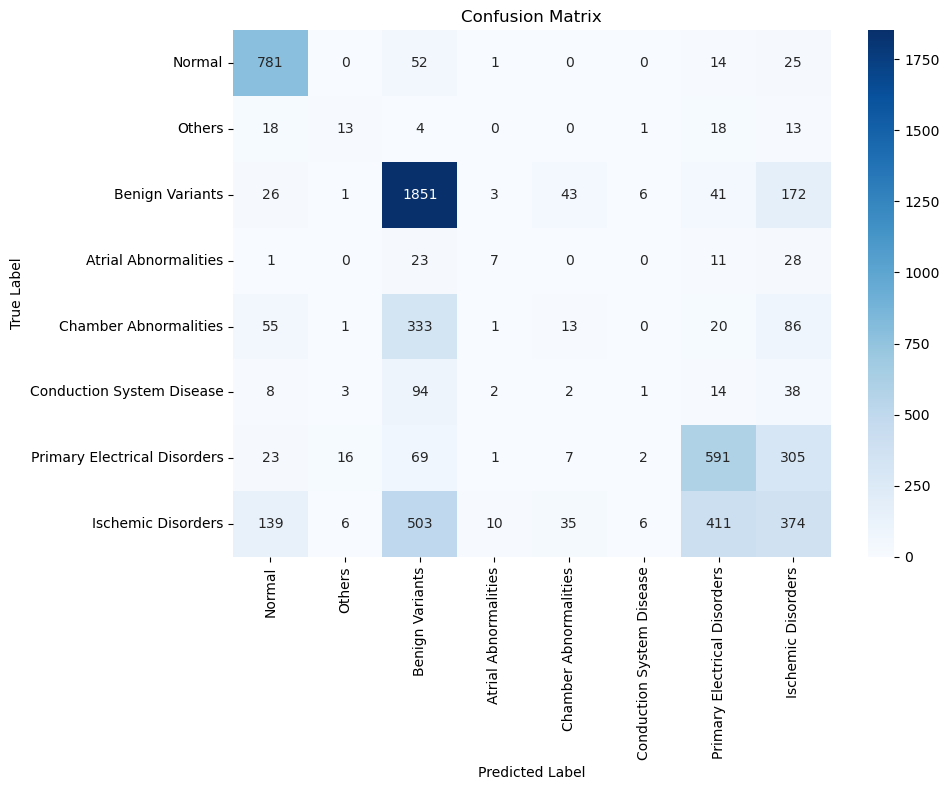


Classification Report with Sensitivity and Specificity:
Class           Sensitivity  Specificity  F1-Score     Support   
------------------------------------------------------------
Normal          0.8946       0.9504       0.8119       873       
Others          0.1940       0.9957       0.2430       67        
Benign Variants 0.8637       0.7420       0.7299       2143      
Atrial Abnormalities 0.1000       0.9971       0.1474       70        
Chamber Abnormalities 0.0255       0.9850       0.0427       509       
Conduction System Disease 0.0062       0.9976       0.0112       162       
Primary Electrical Disorders 0.5828       0.9003       0.5539       1014      
Ischemic Disorders 0.2520       0.8621       0.2962       1484      
------------------------------------------------------------
macro avg       0.3649       0.9288       0.3545       6322      
weighted avg    0.5743       0.8560       0.5258       6322      


In [35]:
# Get predictions on test set
print("\nEvaluating model on test set...")
y_pred = model_trainer.predict(X_test)
y_pred_proba = model_trainer.predict_proba(X_test)

# Map numeric codes back to category names for visualization
inv_mapping = {v: k for k, v in label_mapping.items()}
ordered_classes = [inv_mapping[i] for i in range(len(inv_mapping))]

# Plot confusion matrix
print("\nConfusion Matrix:")
visualizer.plot_multiclass_confusion_matrix(y_test_encoded, y_pred, ordered_classes)


ROC Curves (One-vs-All):


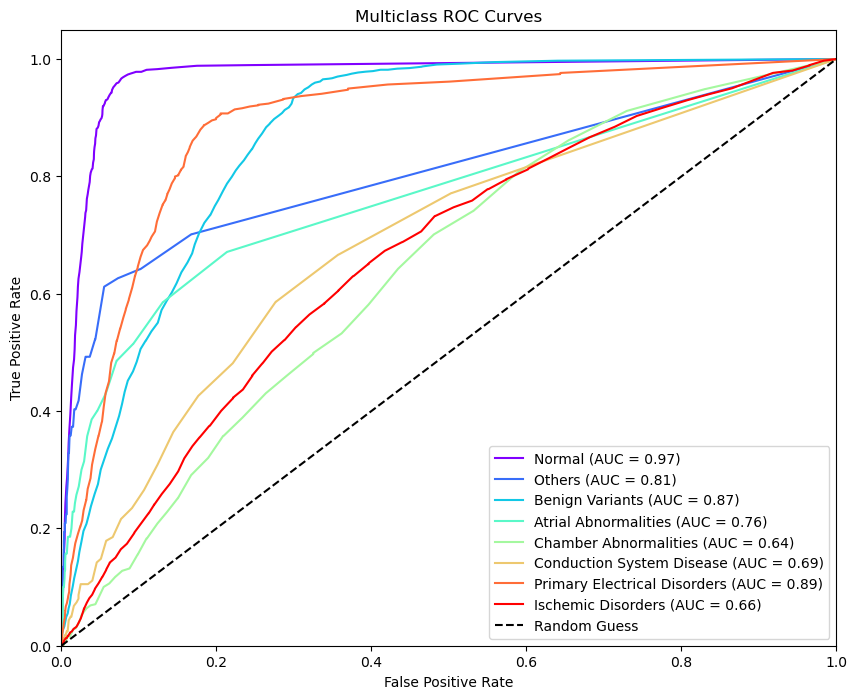


ROC Curves (One-vs-Normal):


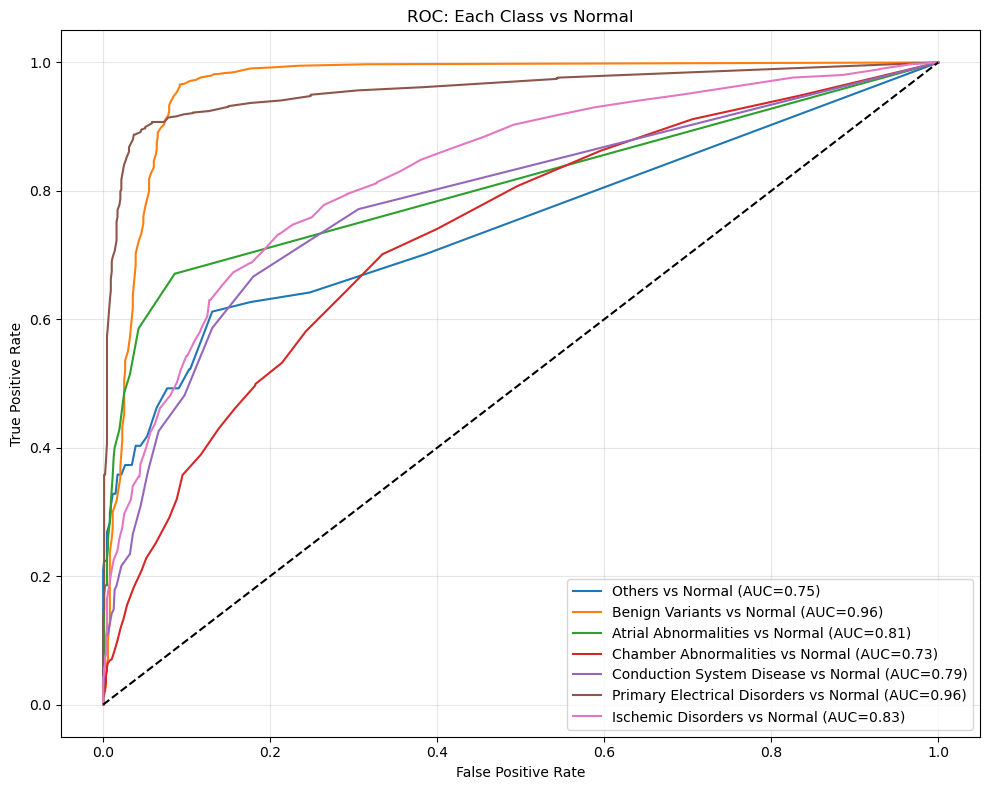


ROC AUC Values:
  Normal: 0.972
  Others: 0.805
  Benign Variants: 0.869
  Atrial Abnormalities: 0.764
  Chamber Abnormalities: 0.641
  Conduction System Disease: 0.686
  Primary Electrical Disorders: 0.890
  Ischemic Disorders: 0.662


In [36]:
# Plot ROC curves for all classes
print("\nROC Curves (One-vs-All):")
roc_auc = visualizer.plot_one_vs_all_multiclass_roc(y_test_encoded, y_pred_proba, ordered_classes)

# Plot ROC curves for each condition vs normal
print("\nROC Curves (One-vs-Normal):")
visualizer.plot_one_vs_normal_roc(y_test_encoded, y_pred_proba, ordered_classes, normal_idx=0)

# Summarize ROC AUC values
print("\nROC AUC Values:")
for i, class_name in enumerate(ordered_classes):
    print(f"  {class_name}: {roc_auc[i]:.3f}")


Performing cross-validation analysis...
2025-02-27 00:10:34 - cross_validate took 0.08 minutes


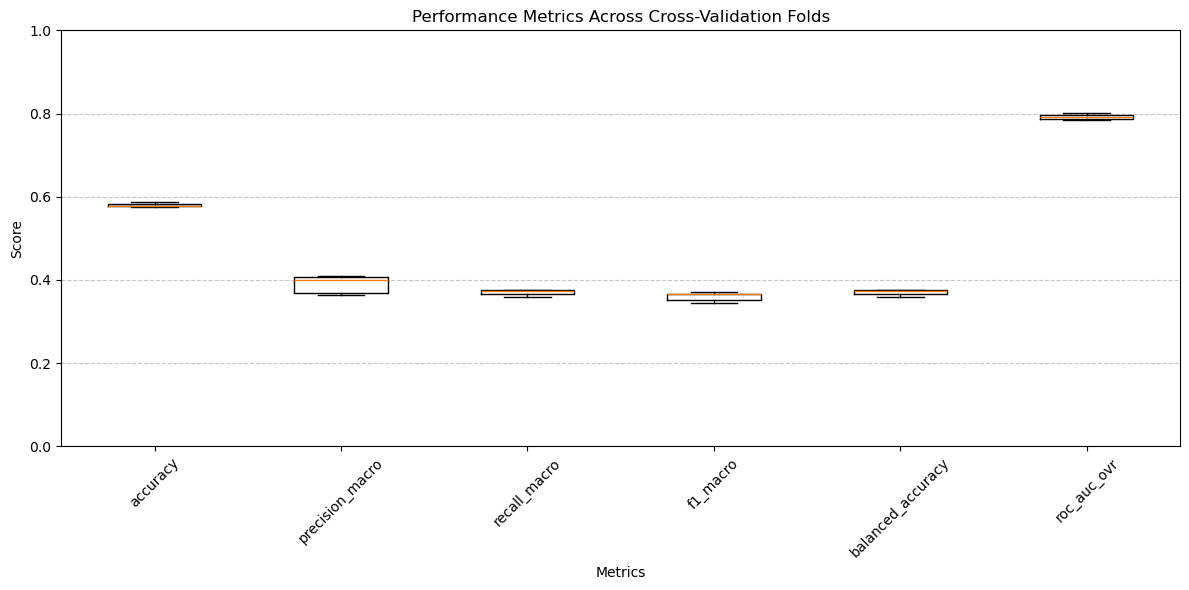


Cross-validation performance summary:


,Metric,Mean,Std
0,test_accuracy,0.5800,0.0048
1,test_precision_macro,0.3894,0.0202
2,test_recall_macro,0.3700,0.0064
3,test_f1_macro,0.3603,0.0098
4,test_balanced_accuracy,0.3700,0.0064
5,test_roc_auc_ovr,0.7922,0.0057


In [37]:
# Perform cross-validation
print("\nPerforming cross-validation analysis...")
cv_results = model_trainer.cross_validate(X_train, y_train, cv=5)

# Visualize cross-validation results
visualizer.plot_cv_results(cv_results, multiclass=True)

# Create CV performance summary
metrics = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 
           'test_f1_macro', 'test_balanced_accuracy', 'test_roc_auc_ovr']

cv_summary = pd.DataFrame({
    'Metric': metrics,
    'Mean': [np.mean(cv_results[m]) for m in metrics],
    'Std': [np.std(cv_results[m]) for m in metrics]
}).round(4)

print("\nCross-validation performance summary:")
display(cv_summary)


Analyzing feature importance...
2025-02-27 00:10:48 - analyze_feature_importance took 0.23 minutes


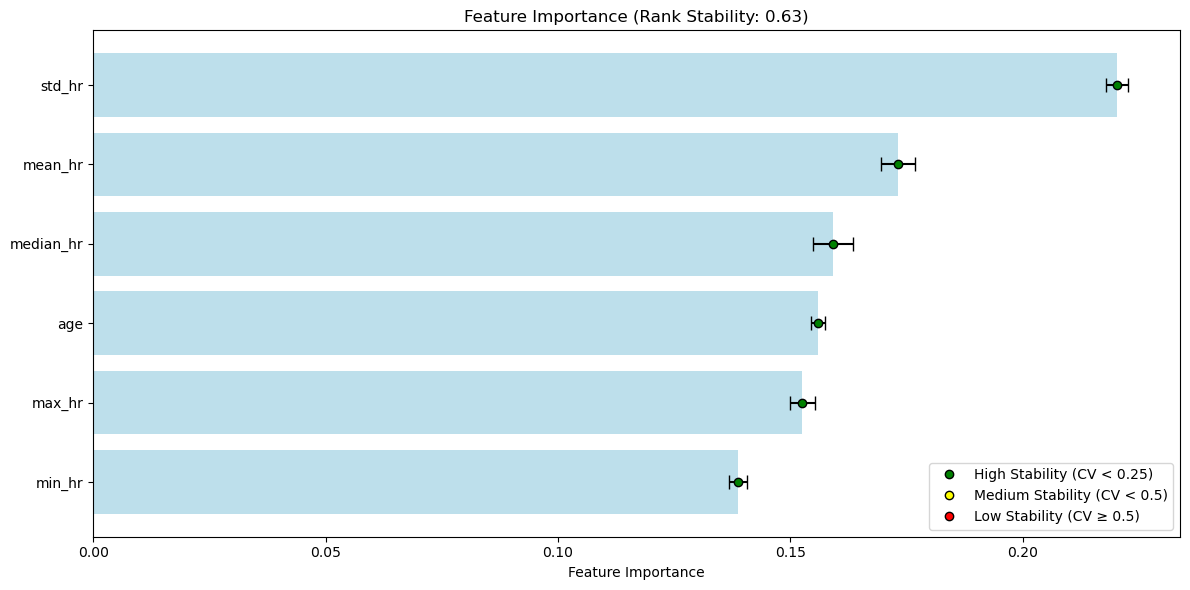


Feature importance ranking:


,Feature,Importance,Std Dev,CV (Stability)
0,std_hr,0.220369,0.002375,0.010777
1,mean_hr,0.173193,0.003617,0.020882
2,median_hr,0.159122,0.004283,0.026918
3,age,0.155897,0.001527,0.009795
4,max_hr,0.152626,0.002640,0.017294
5,min_hr,0.138793,0.001940,0.013977


Overall rank stability: 0.628


In [38]:
# Analyze feature importance with stability assessment
print("\nAnalyzing feature importance...")
importance_results = model_trainer.analyze_feature_importance(
    X_train, y_train, n_iterations=20
)

# Visualize feature importance
visualizer.plot_feature_importance(importance_results)

# Create feature importance table
importance_df = pd.DataFrame({
    'Feature': importance_results['features'],
    'Importance': importance_results['mean_importance'],
    'Std Dev': importance_results['std_importance'],
    'CV (Stability)': importance_results['cv']
})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nFeature importance ranking:")
display(importance_df)

# Print stability assessment
print(f"Overall rank stability: {importance_results['rank_stability']:.3f}")


Visualizing decision boundaries in PCA space...
Binary classification (Normal vs. Abnormal):


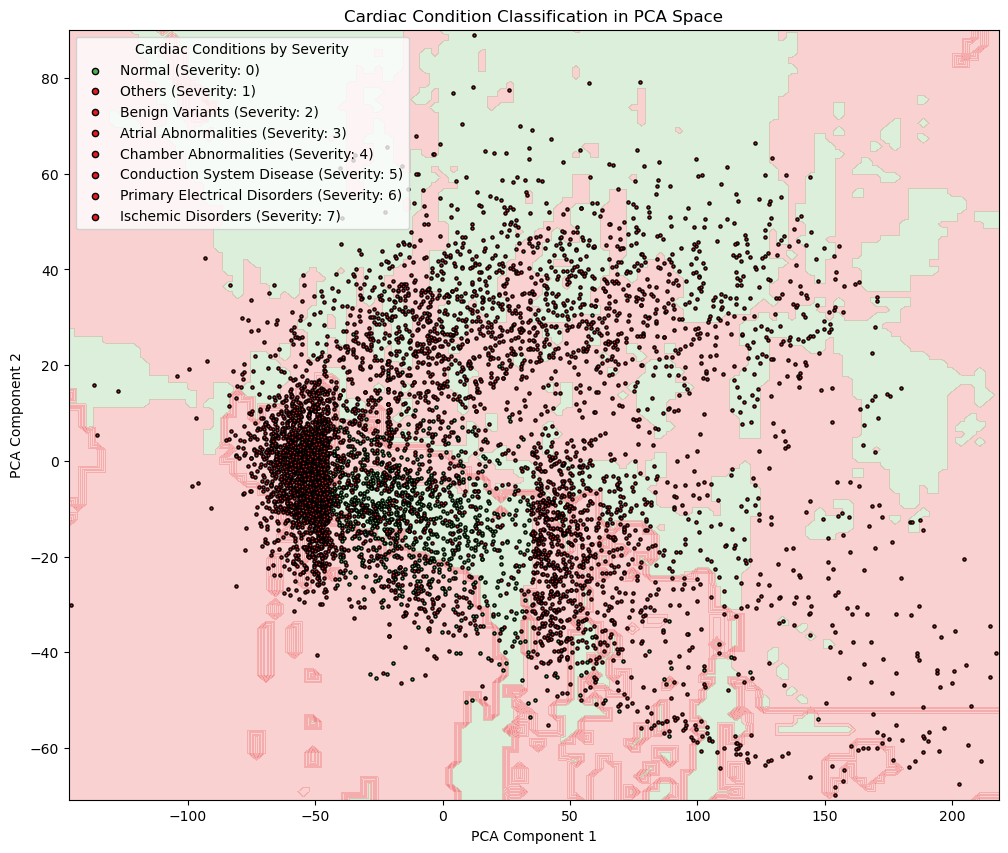


Multiclass classification (all cardiac conditions):


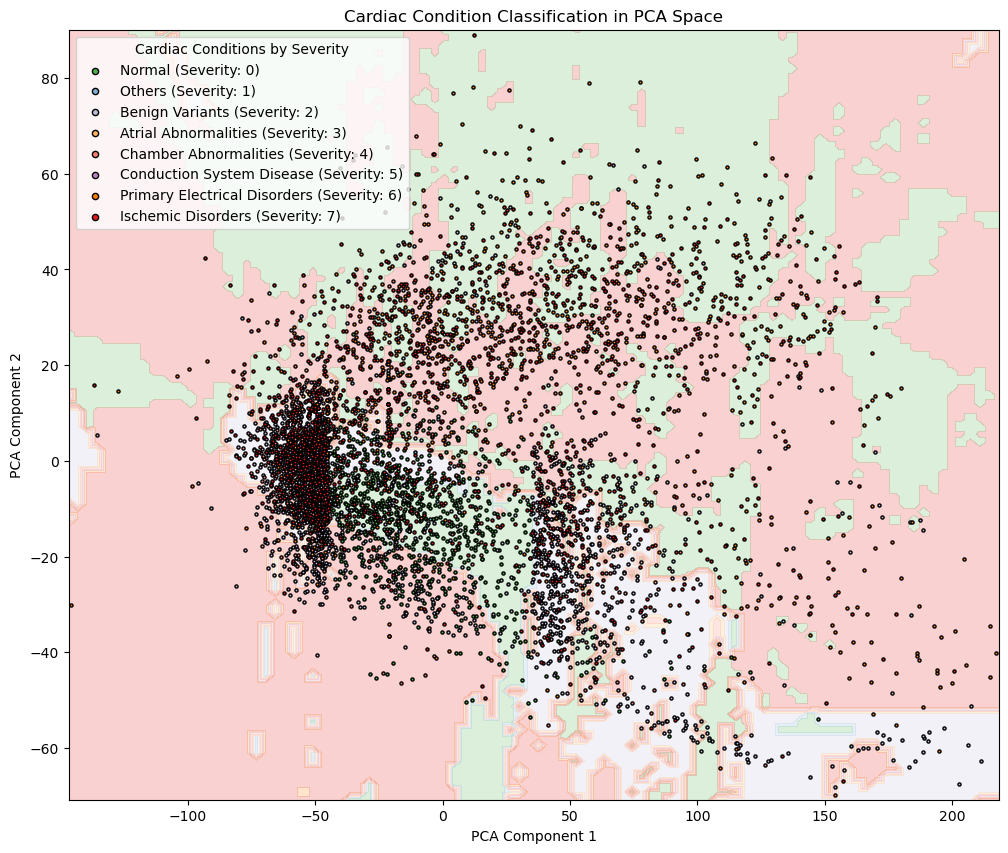

array([[-52.07884552,  -3.23909661],
       [ 20.55985307,  42.93178387],
       [-53.29103907, -10.90683006],
       ...,
       [-35.69195484,  10.49934521],
       [ 28.53511995, -35.97912674],
       [ 63.5281085 ,  16.29732256]])

In [39]:
# Visualize decision boundaries in PCA space
print("\nVisualizing decision boundaries in PCA space...")

# # Binary visualization (Normal vs. Abnormal)
print("Binary classification (Normal vs. Abnormal):")
BoundaryVisualizer.plot_decision_space(
    X_test_processed, 
    y_test_encoded, 
    model_trainer.model, 
    ordered_classes, 
    binary=True
)

# Multiclass visualization (all cardiac conditions)
print("\nMulticlass classification (all cardiac conditions):")
BoundaryVisualizer.plot_decision_space(
    X_test_processed, 
    y_test_encoded, 
    model_trainer.model, 
    ordered_classes, 
    binary=False
)

In [40]:
from datetime import datetime

# Create output directory
output_dir = './Results/RF_model'
os.makedirs(output_dir, exist_ok=True)

# Save the model
model_path = os.path.join(output_dir, 'ecg_rf_model.joblib')
model_trainer.save(model_path)
print(f"\nModel saved to: {model_path}")

# Create summary of model development
with open(os.path.join(output_dir, 'model_summary.txt'), 'w') as f:
    f.write("ECG Classification Model Summary\n")
    f.write("==============================\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Model Configuration:\n")
    f.write(f"- n_estimators: {model_trainer.n_estimators}\n")
    f.write(f"- feature_scaling: {model_trainer.feature_scaling}\n")
    f.write(f"- class_weight: {model_trainer.class_weight}\n\n")
    
    f.write("Features (by importance):\n")
    for i, row in importance_df.iterrows():
        f.write(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}\n")
    
    f.write("\nPerformance Metrics:\n")
    for i, row in cv_summary.iterrows():
        f.write(f"- {row['Metric']}: {row['Mean']:.4f} ± {row['Std']:.4f}\n")

print("Model development summary saved.")


Model saved to: ./Results/RF_model/ecg_rf_model.joblib
Model development summary saved.


# ECG Model Problems & Fixes

## The Issues

* **Way too few features** - Look at that PCA plot - everything's a mess! HR metrics + age aren't enough to tell heart conditions apart.

* **Crazy imbalanced data** - Benign Variants class is HUGE (~10k samples) compared to others. No wonder my model just predicts that for almost everything!

* **Scary mistakes** - 139 Ischemic cases labeled as Normal?! That's dangerous in real life.

* **Duplicate info** - Mean HR and median HR are basically identical (0.99 correlation). Just wasting space here.

## Quick Fix Plan

1. **Better features!** 
   - Add actual ECG wave measurements (PR intervals, QRS width, ST elevation)
   - These will catch what HR metrics miss

2. **Two-step approach**
   - First: Normal or Not? (already works ok)
   - Then: Which specific condition?

3. **Balance the classes**
   - Generate synthetic examples for the small classes
   - Make dangerous misclassifications cost more

My first move is getting those ECG morphology features in. Nothing else matters if the model can't see the real signs of each condition!